<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment03/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

### Import

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 539, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 539 (delta 61), reused 25 (delta 20), pack-reused 368 (from 3)
Receiving objects: 100% (539/539), 24.50 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (150/150), done.
PCD  sample_data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [194 194 194 ...   0   0   0]
 [196 196 196 ...   0   0   0]
 [254 254 254 ... 255 255 255]]


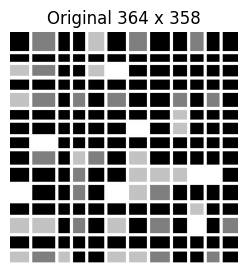

In [3]:
img_path = '/content/PCD/PCD_Assignment03/images/grid.jpg'

img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img = img_as_float(img)

# print(img.shape)
print(img)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='gray')
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

### **1 Segmentasi**

####  **1.1 Pixel based**



##### 1.1.1 Basic Thresholding

##### 1.1.2 Adaptive Thresholding

##### 1.1.3 Probability Thresholding

####  **1.2 Region based**

##### 1.2.1 Region Growing

##### 1.2.2 Watershed / Flood fill

##### 1.2.3 Clustering

#### **1.3 Feature based / Detection**

##### 1.3.1 Sliding Window

### **2 Morphological Process**